<b> EDA and feature engineering </b> notebook (Nr 2) for <b>Project 2</b> of General Assembly DSIR-0320 <br>
by Martijn de Vries </br>
martijndevries91@gmail.com

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sys

Now that all the data is cleaned, it's time to get a sense of which variables would make sense to include in the model, and how we would encode them

In [2]:
df_train = pd.read_csv('../datasets/train_cleaned.csv', dtype={'MS SubClass':'object'})

In [3]:
#Let's start with countable features
for col in df_train.columns:
    if df_train[col].dtype != 'object':
        print(col)

Id
Lot Frontage
Lot Area
Overall Qual
Overall Cond
Year Built
Year Remod/Add
Mas Vnr Area
BsmtFin SF 1
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
1st Flr SF
2nd Flr SF
Low Qual Fin SF
Gr Liv Area
Bsmt Full Bath
Bsmt Half Bath
Full Bath
Half Bath
Bedroom AbvGr
Kitchen AbvGr
TotRms AbvGrd
Fireplaces
Garage Yr Blt
Garage Cars
Garage Area
Wood Deck SF
Open Porch SF
Enclosed Porch
3Ssn Porch
Screen Porch
Pool Area
Misc Val
Mo Sold
Yr Sold
SalePrice


Now let's use a heatmap to see how these features correlate with sale price

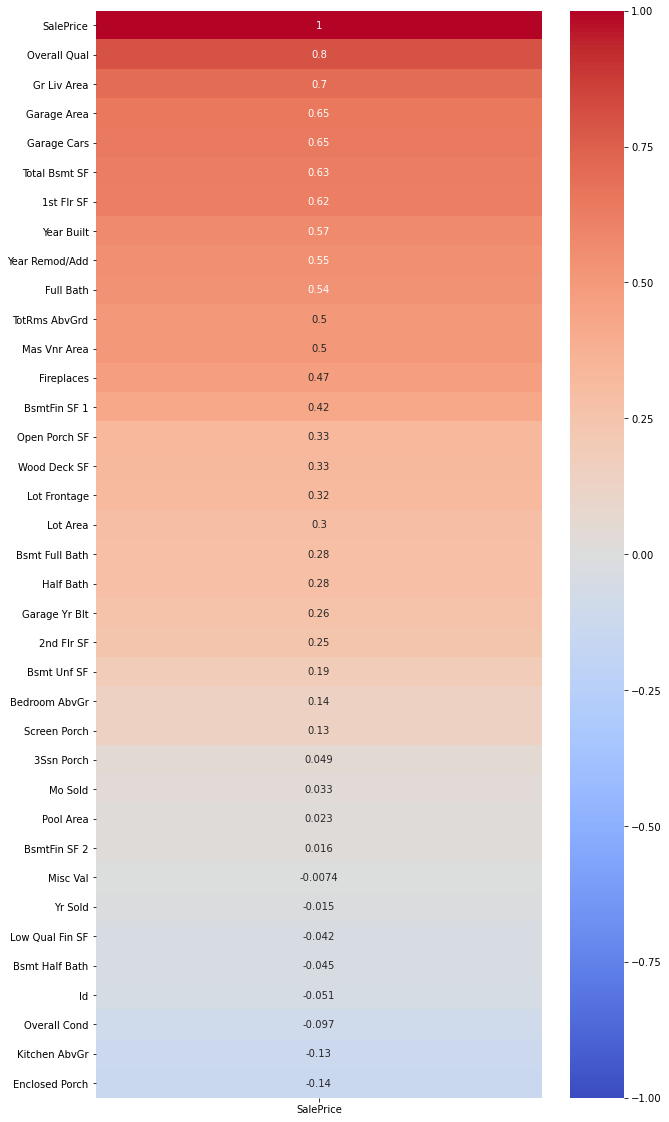

In [4]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), cmap='coolwarm', vmin=-1, vmax=1, annot=True);

It seems there are a few numerical features that strongly correlate with sale price, great.

It occurs to me that some close related features could probably be combined to make the model more simple. Let's start with living area - maybe we should just make a new parameter 'tot_area' that sums the above grade living area ('Gr Liv Area'), and the basement area ('Total Bsmt SF').

First, let's see how well these features are correlated (ie does it make sense to combine them?)

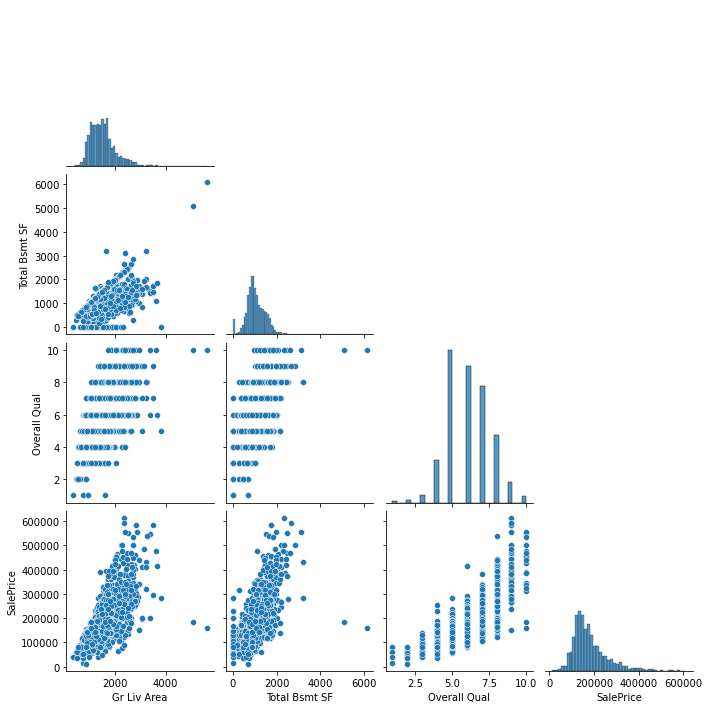

In [5]:
area_features = ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'SalePrice']
sns.pairplot(df_train[area_features], corner=True);

Yup, they are clearly correlated and seem to relate to the sale price in similar ways. There are two outliers that do look pretty suspicious: the two houses in the dataset with the largest above-grade living area, and massive basement space to boot, plus an excellent quality rating, sold for only around 170k dollars. What's going on here?

In [6]:
cols = ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'Functional', 'MS Zoning',  'MS SubClass', 'SalePrice']
df_train[df_train['Gr Liv Area'] > 4000][cols]

,Gr Liv Area,Total Bsmt SF,Overall Qual,Functional,MS Zoning,MS SubClass,SalePrice
960,5642,6110.0,10,Typ,RL,060,160000
1885,5095,5095.0,10,Typ,RL,020,183850


Nothing stand out in the columns that I can think of checking out - these places are sold for residential living, have an excellent quality rating, and have a 'typical' functionality rating. I'm wondering if there might some kind of data entry error here. For house 1885, it seems like a big coincidence that the square footage for above and below ground is the exact same. 
Either way - these outliers are egregious enough, that we should just get rid of them I think

In [7]:
inds = df_train[df_train['Gr Liv Area'] > 4000][cols].index
df_train.drop(index=inds, inplace=True)

In [8]:
df_train['tot_area'] = df_train['Gr Liv Area']  + df_train['Total Bsmt SF']

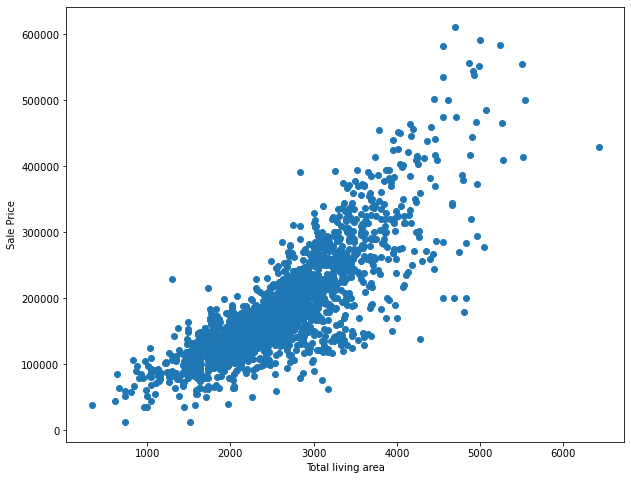

In [9]:
#how does this new variable correlate with sale price?
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_train['tot_area'], df_train['SalePrice'])
ax.set_xlabel('Total living area')
ax.set_ylabel('Sale Price')
plt.show()

Next: there are a lot of columns related to the Garage. We should come up with a way to condense this information, perhaps into a single 'garage rating' parameter or something like that. From the correlation heatmap above, it seems that 'Garage area' correlates highly with saleprice. So perhaps we should use that as a starting point, and modulate that value based on a few other things garage qualities

In [10]:
gar_cols = [col for col in df_train.columns if 'Garage' in col]
df_train[gar_cols].head()

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
0,Attchd,1976.0,RFn,2,475.0,TA,TA
1,Attchd,1997.0,RFn,2,559.0,TA,TA
2,Detchd,1953.0,Unf,1,246.0,TA,TA
3,BuiltIn,2007.0,Fin,2,400.0,TA,TA
4,Detchd,1957.0,Unf,2,484.0,TA,TA


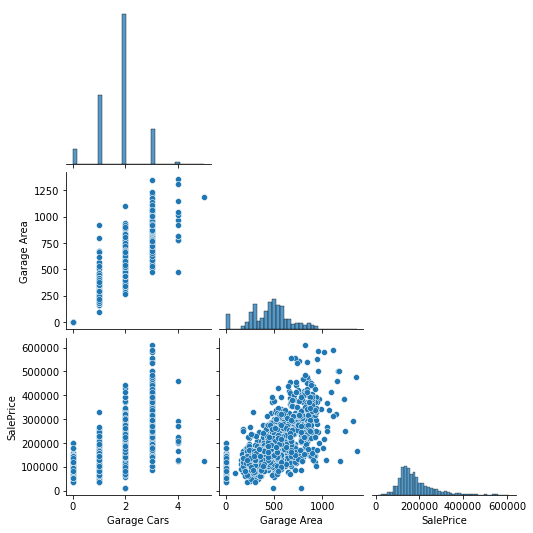

In [11]:
#Let's make a pair plot for the 3 numerical values here
gar_num_features = ['Garage Cars', 'Garage Area', 'SalePrice']
sns.pairplot(df_train[gar_num_features], corner=True);

I think that 'Garage Cars' and 'Garage Area' are correlated enough (bigger garage = more cars), that leaving out 'Garage Cars' is not a very big deal - most of that information is already contained in 'Garage Area'.

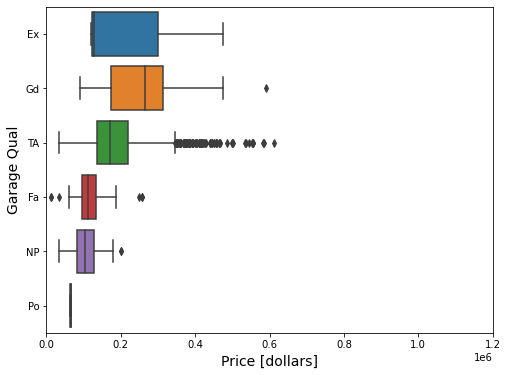

TA    1831
NP     113
Fa      82
Gd      18
Ex       3
Po       2
Name: Garage Qual, dtype: int64

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_train, x="SalePrice", y="Garage Qual",order=['Ex', 'Gd', 'TA', 'Fa', 'NP', 'Po'])
ax.set_xlabel('Price [dollars]', fontsize=14)
ax.set_ylabel('Garage Qual', fontsize=14)
ax.set_xlim(0, 1.2e6)  
plt.show()

df_train['Garage Qual'].value_counts()

How can we use this to modulate the area? We could do the following: 
1) Obtain the increase/decrease in house sale price for each Garage category, relative to having no garage
2) Use those average increase/decrease to modulate the garage area

In [13]:
#get mean house sale price for each garage category
df_grouped = df_train.groupby(by="Garage Qual")['SalePrice'].mean()
bad_to_good = ['Po', 'NP', 'Fa', 'TA', 'Gd', 'Ex']
df_grouped = df_grouped.reindex(bad_to_good)
df_grouped

Garage Qual
Po     65000.000000
NP    105669.150442
Fa    116184.890244
TA    188310.172583
Gd    262989.277778
Ex    241000.000000
Name: SalePrice, dtype: float64

Then we set the benchmark at garages with a TA rating

In [14]:
df_grouped -= df_grouped['NP']
gar_qual_coefs = df_grouped/df_grouped['TA']
print(gar_qual_coefs)

Garage Qual
Po   -0.492118
NP    0.000000
Fa    0.127246
TA    1.000000
Gd    1.903657
Ex    1.637575
Name: SalePrice, dtype: float64


Great! We can use these coefficients and multiply them with the garage area to get some abstract representation of how much the garage is worth. Remember we are building a predictive model, not an inferential one - so I don't care too much about the interpretability of the features.

What about Garage Condition? My first thought is that there is likely to be a lot of overlap between Garage 'Quality' and 'Condition'. Let's check this

In [15]:
df_train.loc[df_train['Garage Qual'] != df_train['Garage Cond'], ['Garage Qual', 'Garage Cond']]

,Garage Qual,Garage Cond
43,Fa,TA
45,Fa,TA
77,Fa,TA
175,TA,Fa
183,Fa,Po
...,...,...
1961,Fa,TA
1964,Gd,TA
1974,Gd,TA
2028,Gd,TA


Only 96 rows, and in most cases the difference is only one rank (ie between Typical and Fair). So I'm going to ignore this one.

For Garage Type, I will follow the same procedure as for Garage Qual

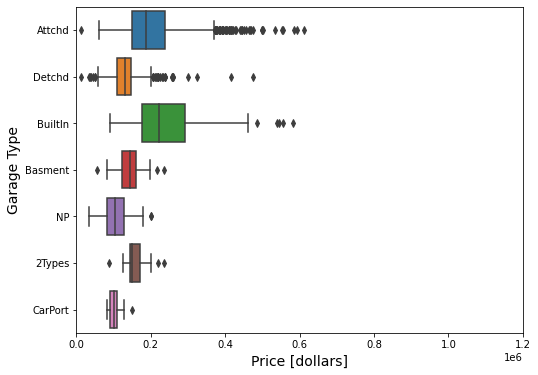

Attchd     1211
Detchd      536
BuiltIn     132
NP          113
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_train, x="SalePrice", y="Garage Type")
ax.set_xlabel('Price [dollars]', fontsize=14)
ax.set_ylabel('Garage Type', fontsize=14)
ax.set_xlim(0, 1.2e6)  
plt.show()
df_train['Garage Type'].value_counts()

In [17]:
df_grouped = df_train.groupby(by="Garage Type")['SalePrice'].mean()
#bad_to_good = ['Po', 'NP', 'Fa', 'TA', 'Gd', 'Ex']
#df_grouped = df_grouped.reindex(bad_to_good)
df_grouped -= df_grouped['NP']
gar_type_coefs = df_grouped / df_grouped['Attchd']
gar_type_coefs

Garage Type
2Types     0.518126
Attchd     1.000000
Basment    0.377902
BuiltIn    1.430358
CarPort   -0.018563
Detchd     0.266166
NP         0.000000
Name: SalePrice, dtype: float64

In [18]:
def calc_gar_adj(row, type_coefs, qual_coefs):
    """
    calculate adjusted garage area based on 
    1) the actual square footage
    2) the garage quality
    3) the garage type 
    the type_coefs and qual_coefs should be pandas series, so that I can look up the appropriate coefficient based on input quality and type
    """
    gtype = row['Garage Type']
    area = row['Garage Area']
    gqual = row['Garage Qual']
    return area * (type_coefs[gtype] + qual_coefs[gqual])/2

In [19]:
#Using an actual for loop rather than map, because I don't know a better way to call a function with multiple arguments in .map() or .apply()
gar_adj_l = []
for rowind in df_train.index:
    row = df_train.loc[rowind]
    gar_adj_l.append(calc_gar_adj(row, gar_type_coefs, gar_qual_coefs))
df_train['gar_adj_area'] = gar_adj_l


<AxesSubplot:>

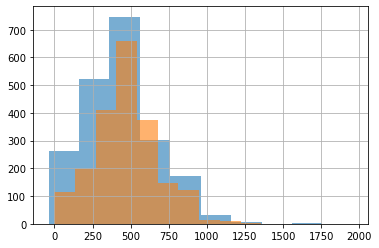

In [20]:
#Compare area and adjusted area
df_train['gar_adj_area'].hist(alpha=0.6)
df_train['Garage Area'].hist(alpha=0.6)

In [21]:
#check the correlation between 

In [22]:
#Correlation between sales price and area vs adjusted area
print(df_train['SalePrice'].corr(df_train['gar_adj_area']))
print(df_train['SalePrice'].corr(df_train['Garage Area']))

0.7560199069230171
0.6554524749795821


What else do I want to incorporate in the model? Year Built and Year Remodeled seem like obvious candidates - let's see what those pairplots look like

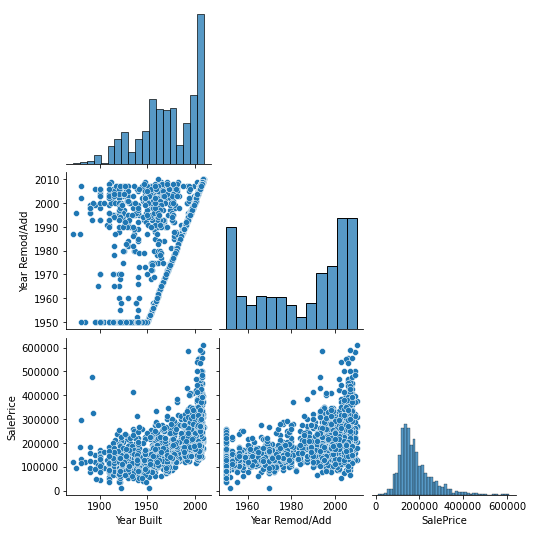

In [23]:
#Let's make a pair plot for the 3 numerical values here
yr_features = ['Year Built', 'Year Remod/Add', 'SalePrice']
sns.pairplot(df_train[yr_features], corner=True);

Maybe a log transform would be more appropriate?

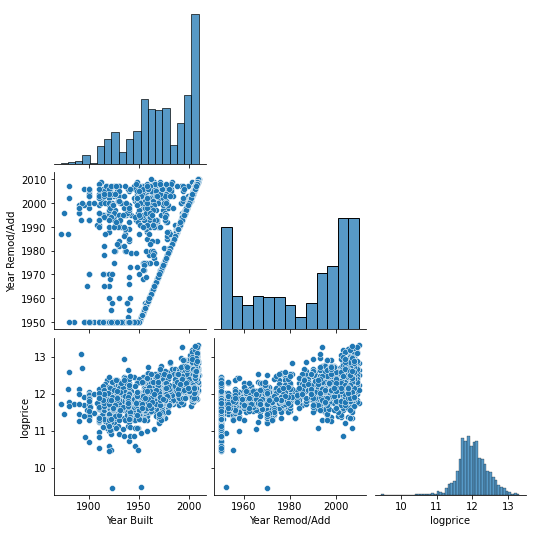

In [24]:
df_train['logprice'] = np.log(df_train['SalePrice'])
sns.pairplot(df_train[['Year Built', 'Year Remod/Add', 'logprice']], corner=True);

It seems that it might be! Although this introduces two new outliers. Let's investigate those

In [25]:
cols = ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'Functional', 'MS Zoning',  'MS SubClass', 'SalePrice']
df_train[df_train['logprice'] < 10][cols]

,Gr Liv Area,Total Bsmt SF,Overall Qual,Functional,MS Zoning,MS SubClass,SalePrice
183,733,0.0,1,Sal,A (agr),020,13100
1628,832,678.0,2,Typ,RM,030,12789


There seem to be good reasons for those prices, just looking at these columns... both properties are small, the houseing quality is low. And for house 183 the zoning is agricultural, and it was a salvage sale. Maybe I should include the 'functional' variable as well in the model, to help account for this

In [26]:
df_train['Functional'].value_counts()

Typ     1913
Min1      42
Min2      42
Mod       29
Maj1      12
Maj2       7
Sev        2
Sal        2
Name: Functional, dtype: int64

I don't want to create so many new variables, so I can make this a little coarser by combining categories: eg Min1 and Min2, Maj1 an and Maj2, Sev and Sal:

In [27]:
func_dic = {'Typ':'Typ', 'Min1':'Min', 'Min2':'Min', 'Mod':'Mod', 'Maj1':'Maj', 'Maj2':'Maj', 'Sev':'Sev', 'Sal':'Sev'}
df_train['Func'] = df_train['Functional'].map(lambda func: func_dic[func])
df_train['Func'].value_counts()

Typ    1913
Min      84
Mod      29
Maj      19
Sev       4
Name: Func, dtype: int64

Another categorical variable that might have a big effect is whetehr there is a pool or not, but if we do a value_counts:

In [28]:
df_train['Pool QC'].value_counts()

NP    2041
Gd       3
TA       2
Fa       2
Ex       1
Name: Pool QC, dtype: int64

There are only a handful of houses with a pool, so maybe not worth including.

Finally, I do think some categorical indication of location is important - for this we could use 'MS Zoning'. What do the boxplots look like?

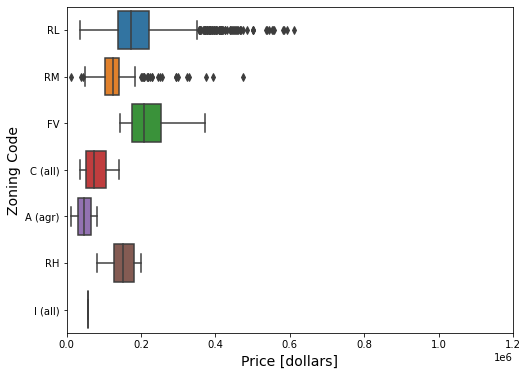

RL         1596
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_train, x="SalePrice", y="MS Zoning")
ax.set_xlabel('Price [dollars]', fontsize=14)
ax.set_ylabel('Zoning Code', fontsize=14)
ax.set_xlim(0, 1.2e6)  
plt.show()
df_train['MS Zoning'].value_counts()

Seems like that's definitely worth including. So to sum it all up, we have
1) home quality
2) adjusted living area
3) adjusted garage area
4) year built
5) year remodeled
6) Home Functionality
6) MS zoning

For the numerical columns, does it make sense to fit them against the log of the price? 

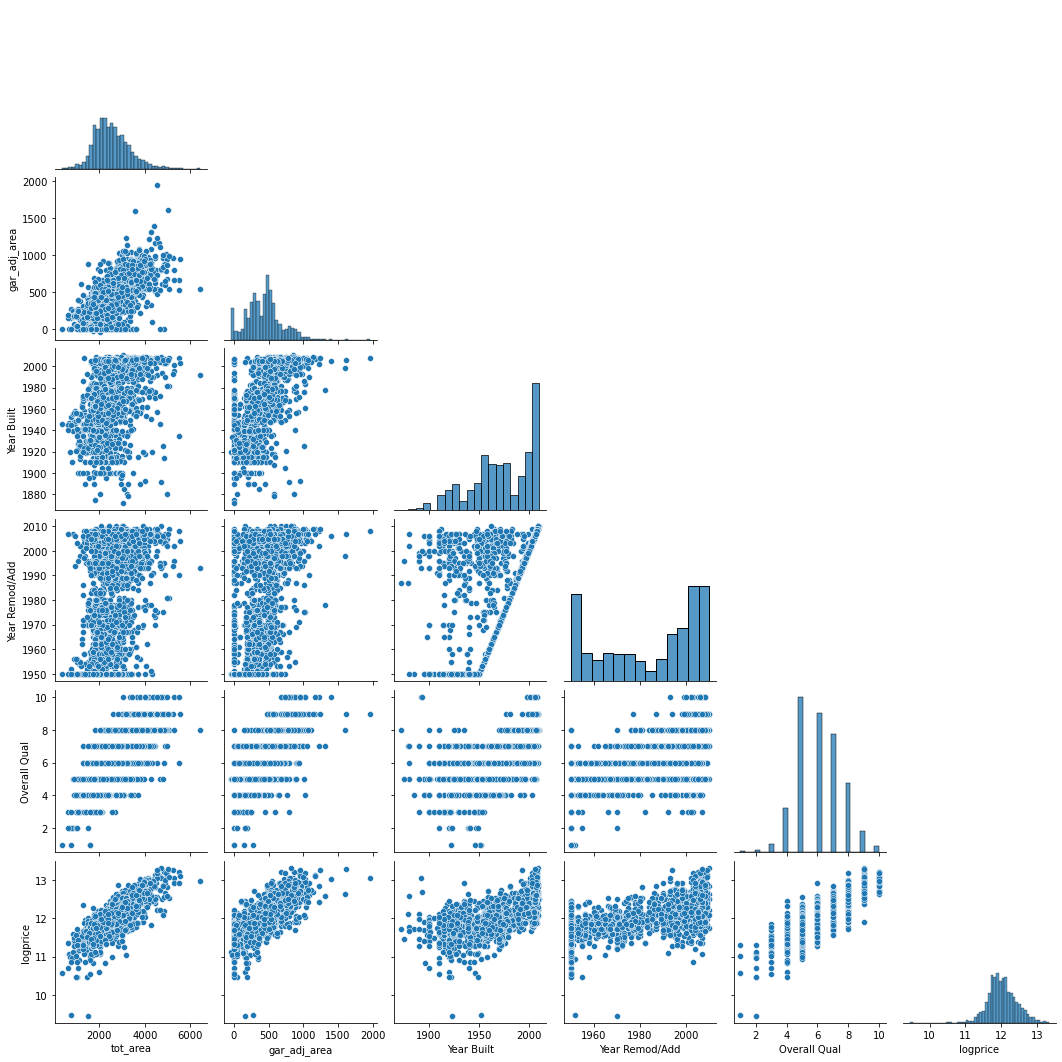

In [30]:
features = ['tot_area', 'gar_adj_area', 'Year Built', 'Year Remod/Add', 'Overall Qual', 'logprice']
sns.pairplot(df_train[features], corner=True);

Looks pretty reasonable to me! Those low-price outliers are still annoying, they are much worse in logspace than in linear space. But hopefully the 'Overall Qual', 'Func' and 'Zoning' features can take care of that somewhat.

In [31]:
#dummify zoning columns and home functionality columns
df_train_dummies = pd.get_dummies(df_train, columns=['MS Zoning', 'Func'])
df_train_dummies.drop(columns=['MS Zoning_RL', 'Func_Typ'], inplace=True) #drop baseline (most common occurence)

In [32]:
#Create a dataframe with all my feature-engineered columns, and the target variable, that I can feed directly to the model
features = ['tot_area', 'gar_adj_area', 'Year Built', 'Year Remod/Add', 'Overall Qual']
for col in df_train_dummies.columns:
    if ('MS Zoning' in col) or ('Func_' in col):
        features.append(col)
X = df_train_dummies[features]
features.append('logprice')
y = df_train_dummies['logprice']
df_model = df_train_dummies[features]

We should now put this entire process in a function, so we can generate feature-engineered data for both the train and test data

In [33]:
def calc_gar_adj(row, type_coefs, qual_coefs):
    """
    calculate adjusted garage area based on 
    1) the actual square footage
    2) the garage quality
    3) the garage type 
    the type_coefs and qual_coefs should be pandas series, so that I can look up the appropriate coefficient based on input quality and type
    """
    gtype = row['Garage Type']
    area = row['Garage Area']
    gqual = row['Garage Qual']
    return area * (type_coefs[gtype] + qual_coefs[gqual])/2

def feature_engineer_m1(df_train, df_test):
    """
    Feature engineer and extract the features that we want to fit in our model, for both the train and the test data
    These are 1) the total living area (based on above grade and basement living area),
    2) the garage area (adjusted by garage quality and garage type), 3) the overall quality of the house
    4) the year built, 5) the year the house was remodeled or added to, 6) the home functionality, and 7) the Zoning code of the building
    """
    
    #For the train dataframe, drop the two outliers with huge living areas
    inds = df_train[df_train['Gr Liv Area'] > 4000][cols].index
    df_train.drop(index=inds, inplace=True)
    
    df_train['tot_area'] = df_train['Gr Liv Area'] + df_train['Total Bsmt SF']
    df_test['tot_area'] = df_test['Gr Liv Area'] + df_test['Total Bsmt SF']
    
    #calc adj gar area
    df_train_gq = df_train.groupby(by="Garage Qual")['SalePrice'].mean()
    gar_qual_coefs = (df_train_gq-df_train_gq['NP'])/df_train_gq['TA']
    
    df_train_gt = df_train.groupby(by="Garage Type")['SalePrice'].mean()
    gar_type_coefs = (df_train_gt-df_train_gt['NP'])/df_train_gt['Attchd']

    gar_adj_train_l, gar_adj_test_l = [],[]
    for rowind in df_train.index:
        row = df_train.loc[rowind]
        gar_adj_train_l.append(calc_gar_adj(row, gar_type_coefs, gar_qual_coefs))
    df_train['gar_adj_area'] = gar_adj_train_l
    
    for rowind in df_test.index:
        row = df_test.loc[rowind]
        gar_adj_test_l.append(calc_gar_adj(row, gar_type_coefs, gar_qual_coefs))
    df_test['gar_adj_area'] = gar_adj_test_l
    
    #Make home functionality categories more coarse
    func_dic = {'Typ':'Typ', 'Min1':'Min', 'Min2':'Min', 'Mod':'Mod', 'Maj1':'Maj', 'Maj2':'Maj', 'Sev':'Sev', 'Sal':'Sev'}
    df_train['Func'] = df_train['Functional'].map(lambda func: func_dic[func])
    df_test['Func'] = df_test['Functional'].map(lambda func: func_dic[func])

    #dummy code home functionality and zoning code
    df_train_dummies = pd.get_dummies(df_train, columns=['MS Zoning', 'Func'])
    df_train_dummies.drop(columns=['MS Zoning_RL', 'Func_Typ'], inplace=True) #drop baseline (most common occurence)
    
    df_test_dummies = pd.get_dummies(df_test, columns=['MS Zoning', 'Func'])
    df_test_dummies.drop(columns=['MS Zoning_RL', 'Func_Typ'], inplace=True) #drop baseline (most common occurence)
    
    #Select features - Need ID as well for the Kaggle submission 
    features = ['Id', 'tot_area', 'gar_adj_area', 'Year Built', 'Year Remod/Add', 'Overall Qual']   
    for col in df_train_dummies.columns:
        if ('MS Zoning' in col) or ('Func_' in col):
            features.append(col)
    #add dummy columns that are in the train data but not the test data
    for feature in features:
        try:
            df_test_dummies[feature]
        except:
            df_test_dummies[feature] = 0
      
    df_model_test = df_test_dummies[features]
    features.append('SalePrice')
    df_model_train = df_train_dummies[features]
    
    #rename columns
    df_model_train = df_model_train.rename(columns={'Year_ Built':'yr_built', 'Year Remod/Add':'yr_remod', 'Overall Qual':'qual'})
    df_model_test = df_model_test.rename(columns={'Year_ Built':'yr_built', 'Year Remod/Add':'yr_remod', 'Overall Qual':'qual'})
    
    return df_model_train, df_model_test

In [ ]:
#Reload train and test data and feed through the feature engineering function
df_train = pd.read_csv('../datasets/train_cleaned.csv', dtype={'MS SubClass':'object'})
df_test = pd.read_csv('../datasets/test_cleaned.csv', dtype={'MS SubClass':'object'})

#feature_engineer_m1(df_train, df_test)
df_fe_train, df_fe_test = feature_engineer_m1(df_train, df_test)

df_fe_train.to_csv('../model_inputs/train_engineerd_m1.csv')
df_fe_test.to_csv('../model_inputs/test_engineerd_m1.csv')